## Import Libraries

In [20]:
import pandas as pd
import torch

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.metrics import root_mean_squared_error

from shanghai_t_dm_utils import read_dataset
from gptq_chronos import GPTQChronosPipeline
from itertools import islice
from tqdm import tqdm

from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM,
    GenerationConfig,
    PreTrainedModel,
)
RESULT_OUTPUT_DIR = "./results"
MODEL_OUTPUT_FOLDER = "../models/shanghai_t_dm/chronos-t5-base"
Path(RESULT_OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

import pandas as pd
from torch.utils.data import Dataset, DataLoader
from datetime import datetime

## Split dataset

In [60]:
# Parameters
num_samples_per_hour = 4
context_window = 96 * num_samples_per_hour  # 48 hours of data, 4 points per hour (every 15 minutes)
prediction_window = 6 * num_samples_per_hour  # 6 hours of data, 4 points per hour

In [61]:
# Load the datasets
t1_dataset_data, t1_dataset_file_names = read_dataset()
t2_dataset_data, t2_dataset_file_names = read_dataset("T2")
data = t1_dataset_data + t2_dataset_data
file_names = t1_dataset_file_names + t2_dataset_file_names

BATCH_SIZE = 32

# Parameters
TRAIN_RATIO = 0.9
VAL_RATIO = 0.05
TEST_RATIO = 0.05

DataFrame ../datasets/Shanghai_T2DM/2029_0_20210526.xls has columns with NaN values:
Date              0
CGM (mg / dl)    13
dtype: int64


In [62]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, context_length, prediction_length):
        self.data = data
        self.context_length = context_length
        self.prediction_length = prediction_length

    def __len__(self):
        # Each dataframe contributes (len(df) - context_length - prediction_length + 1) samples
        return sum(len(df) - self.context_length - self.prediction_length + 1 for df in self.data)

    def __getitem__(self, idx):
        # Find the appropriate dataframe and index within that dataframe
        cumulative_length = 0
        for df in self.data:
            current_length = len(df) - self.context_length - self.prediction_length + 1
            if idx < cumulative_length + current_length:
                local_idx = idx - cumulative_length
                context = df['CGM'].values[local_idx:local_idx + self.context_length]
                target = df['CGM'].values[local_idx + self.context_length:local_idx + self.context_length + self.prediction_length]
                return torch.tensor(context, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)
            cumulative_length += current_length
        raise IndexError("Index out of range in dataset")

train_data = []
val_data = []
test_data = []

for i in range(len(data)):

    num_rows = len(data[i])
    sample_size = context_window + prediction_window

    # Available samples in a single timeseries
    available_samples = (num_rows - sample_size + 1)
    training_samples = int(available_samples*TRAIN_RATIO)
    validation_samples = int(available_samples*VAL_RATIO)
    testing_samples = int(available_samples*TEST_RATIO)

    # Add first part of timeseries in train set, middle part in validation set and last part in test set
    train_data.append(data[i].iloc[:training_samples+sample_size+1])
    val_data.append(data[i].iloc[training_samples+1:training_samples+validation_samples+sample_size+1])
    test_data.append(data[i].iloc[training_samples+validation_samples+1:])

# Create datasets and dataloaders
train_dataset = TimeSeriesDataset(train_data, context_window, prediction_window)
val_dataset = TimeSeriesDataset(val_data, context_window, prediction_window)
test_dataset = TimeSeriesDataset(test_data, context_window, prediction_window)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Get the first batch from train dataloader
first_batch_train = next(iter(train_dataloader))
inputs, targets = first_batch_train
print(f"Train dataloader\nBatches: {len(train_dataloader)}\nInputs shape: {inputs.shape}\nTargets shape: {targets.shape}")

# Get the first batch from val dataloader
first_batch_val = next(iter(val_dataloader))
inputs, targets = first_batch_val
print(f"Train dataloader\nBatches: {len(val_dataloader)}\nInputs shape: {inputs.shape}\nTargets shape: {targets.shape}")

# Get the first batch from test dataloader
first_batch_test = next(iter(test_dataloader))
inputs, targets = first_batch_test
print(f"Test dataloader\nBatches: {len(test_dataloader)}\nInputs shape: {inputs.shape}\nTargets shape: {targets.shape}")

Train dataloader
Batches: 2166
Inputs shape: torch.Size([32, 384])
Targets shape: torch.Size([32, 24])
Train dataloader
Batches: 37
Inputs shape: torch.Size([32, 384])
Targets shape: torch.Size([32, 24])
Test dataloader
Batches: 36
Inputs shape: torch.Size([32, 384])
Targets shape: torch.Size([32, 24])


## Functions to load and test models

In [24]:
import time
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from chronos import ChronosPipeline, ChronosModel, ChronosConfig

# Function to load model with quantization
def load_model(model_name, quantization_bits=None):
    if quantization_bits == 8:
        bnb_config_8bit = BitsAndBytesConfig(load_in_8bit=True)
        pipeline = ChronosPipeline.from_pretrained(model_name,device_map="cuda:0",quantization_config=bnb_config_8bit)
    elif quantization_bits == 4:
        bnb_config_4bit = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type='nf4'
        )
        pipeline = ChronosPipeline.from_pretrained(model_name,device_map="cuda:0",quantization_config=bnb_config_4bit)
    else:
        pipeline = ChronosPipeline.from_pretrained(model_name,device_map="cuda:0")

    return pipeline

# Function to calculate RMSE
def calculate_rmse(predictions, targets):
    return np.sqrt(mean_squared_error(predictions, targets))

# Function to print the dtype, count, and model size of parameters
def print_model_dtype_and_size(model):
    param_dtypes = {}
    dtype_size = {
        torch.float32: 4,
        torch.float16: 2,
        torch.int8: 1,
        torch.uint8: 1
    }
    total_size = 0
    
    for param in model.parameters():
        dtype = param.dtype
        count_param = param.numel()
        if dtype not in param_dtypes:
            param_dtypes[dtype] = 0
        param_dtypes[dtype] += count_param
    
    for dtype, count in param_dtypes.items():
        size = count * dtype_size[dtype]
        total_size += size
        print(f"Dtype: {dtype}, Count: {count}, Size: {size / (1024 ** 2):.2f} MB")
    
    print(f"Total model size: {total_size / (1024 ** 2):.2f} MB")

# Function to perform inference and measure time with tqdm progress bar
def test_model(pipeline, dataloader, settings, num_samples=10):
    
    all_predictions = []
    all_targets = []
    inference_times = []

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Testing"):
            
            start_time = time.time()
            outputs = pipeline.predict(inputs,prediction_length=prediction_window,num_samples=num_samples)
            end_time = time.time()

            # Calculate the low, median, and high quantiles across the second dimension (dimension with size 3)
            quantiles = torch.quantile(outputs.cpu(), q=torch.tensor([0.1, 0.5, 0.9]), dim=1)
            
            # Extract the low, median, and high quantiles
            low = quantiles[0]
            median = quantiles[1]
            high = quantiles[2]
            
            inference_times.append((end_time - start_time)/num_samples)
            
            all_predictions.append(median.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    rmse = calculate_rmse(all_predictions, all_targets)
    avg_inference_time = np.mean(inference_times)
    
    print(f"{setting_name}. RMSE: {rmse}, Avg Inference Time: {avg_inference_time}")
    
    return rmse, avg_inference_time

## Test inference for multiple types of quantization

In [63]:
base_model = "amazon/chronos-t5-small"
settings = {
    "Chronos_Original": [base_model, None],
    #"Chronos_8bits": [base_model,8],
    #"Chronos_4bits": [base_model,4]
    
}

for setting in settings.items():
    
    torch.cuda.empty_cache()
    setting_name = setting[0]
    model_name, quantization_bits = setting[1]

    print(setting_name)
    NUM_SAMPLES = 20 #default 20
    pipeline = load_model(model_name, quantization_bits)
    print_model_dtype_and_size(pipeline.model)
    #test_model(pipeline, test_dataloader, setting_name, NUM_SAMPLES)

Chronos_Original
Dtype: torch.float32, Count: 46154240, Size: 176.06 MB
Total model size: 176.06 MB


### Plot a prediction example

In [64]:
first_batch_train = next(iter(train_dataloader))
inputs, targets = first_batch_train

outputs = pipeline.predict(inputs,prediction_length=prediction_window,num_samples=50)

# Calculate the low, median, and high quantiles across the second dimension (dimension with size 3)
quantiles = torch.quantile(outputs.cpu(), q=torch.tensor([0.1, 0.5, 0.9]), dim=1)

# Extract the low, median, and high quantiles
low = quantiles[0]
median = quantiles[1]
high = quantiles[2]

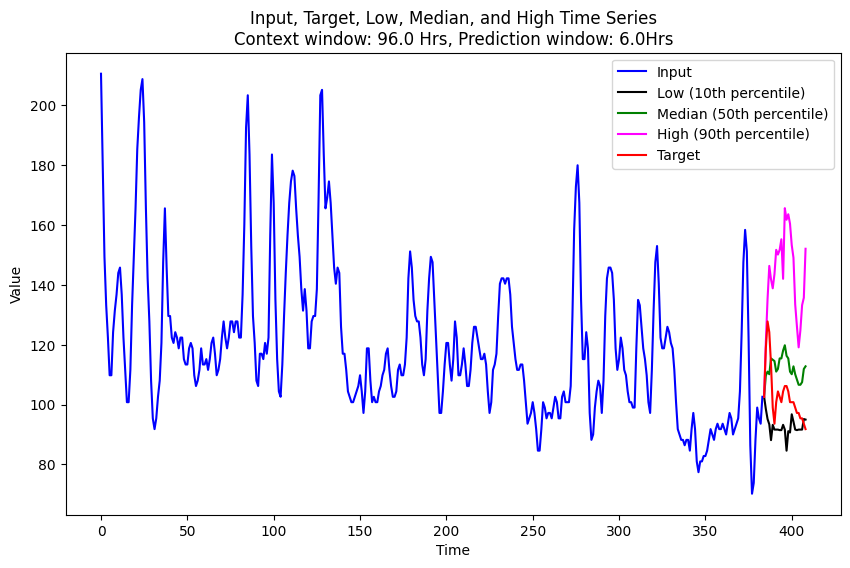

In [65]:
# Convert to numpy arrays for easier plotting
low_np = low.numpy()
median_np = median.numpy()
high_np = high.numpy()
inputs_np = inputs.numpy()
targets_np = targets.numpy()

# Plot the time series for the first record as an example
# Adjust the index to select different records if needed
record_index = 5
# Length of the input time series
time_series_length = inputs_np.shape[1]

plt.figure(figsize=(10, 6))

input_example = inputs_np[record_index]
low_example = np.insert(low_np[record_index],0,input_example[-1])
median_example = np.insert(median_np[record_index],0,input_example[-1])
high_example = np.insert(high_np[record_index],0,input_example[-1])
target_example = np.insert(targets_np[record_index],0,input_example[-1])

# Plot the input time series with a blue line
plt.plot(range(time_series_length), input_example, label='Input', color='blue')

# Plot the model outputs with different colors, starting from the end of the input time series
plt.plot(range(time_series_length, time_series_length + len(low_example)), low_example, label='Low (10th percentile)', color='black')
plt.plot(range(time_series_length, time_series_length + len(median_example)), median_example, label='Median (50th percentile)', color='green')
plt.plot(range(time_series_length, time_series_length + len(high_example)), high_example, label='High (90th percentile)', color='magenta')

# Plot the target values with a blue dotted line, starting from the end of the input time series
plt.plot(range(time_series_length, time_series_length + len(target_example)), target_example, label='Target', color='red')

plt.title(f'Input, Target, Low, Median, and High Time Series\nContext window: {context_window/4} Hrs, Prediction window: {prediction_window/4}Hrs')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.savefig(f'example_prediction_context_window{int(context_window/4)}_prediction_window{int(prediction_window/4)}png')

plt.show()

In [47]:
record_index = 20
low_npasd = np.insert(low_np[record_index],0,inputs_np[record_index][-1])

## Finetuning

Validating: 100%|██████████| 160/160 [00:29<00:00,  5.41it/s]


Epoch [1/1000], Training Loss: 1844.0657, Validation Loss: 1596.8867, Learning Rate: 0.001000


Validating: 100%|██████████| 160/160 [00:29<00:00,  5.42it/s]


Epoch [2/1000], Training Loss: 1838.5952, Validation Loss: 1591.3527, Learning Rate: 0.001000


Validating: 100%|██████████| 160/160 [00:29<00:00,  5.42it/s]


Epoch [3/1000], Training Loss: 1839.9409, Validation Loss: 1612.9655, Learning Rate: 0.001000


Validating: 100%|██████████| 160/160 [00:29<00:00,  5.40it/s]


Epoch [4/1000], Training Loss: 1839.3966, Validation Loss: 1615.3900, Learning Rate: 0.001000


Validating: 100%|██████████| 160/160 [00:29<00:00,  5.43it/s]


Epoch [5/1000], Training Loss: 1843.9650, Validation Loss: 1575.7427, Learning Rate: 0.001000


Validating: 100%|██████████| 160/160 [00:29<00:00,  5.41it/s]


Epoch [6/1000], Training Loss: 1845.0664, Validation Loss: 1562.9995, Learning Rate: 0.001000


Validating: 100%|██████████| 160/160 [00:29<00:00,  5.43it/s]


Epoch [7/1000], Training Loss: 1841.9967, Validation Loss: 1597.0526, Learning Rate: 0.001000


Validating: 100%|██████████| 160/160 [00:29<00:00,  5.42it/s]


Epoch [8/1000], Training Loss: 1835.3865, Validation Loss: 1574.2995, Learning Rate: 0.001000


Validating: 100%|██████████| 160/160 [00:29<00:00,  5.41it/s]


Epoch [9/1000], Training Loss: 1847.6776, Validation Loss: 1588.3810, Learning Rate: 0.001000


Validating: 100%|██████████| 160/160 [00:29<00:00,  5.42it/s]


Epoch [10/1000], Training Loss: 1845.0152, Validation Loss: 1581.5117, Learning Rate: 0.000100


Validating: 100%|██████████| 160/160 [00:29<00:00,  5.42it/s]


Epoch [11/1000], Training Loss: 1832.0457, Validation Loss: 1602.1400, Learning Rate: 0.000100


Validating: 100%|██████████| 160/160 [00:29<00:00,  5.43it/s]


Epoch [12/1000], Training Loss: 1838.3823, Validation Loss: 1598.4487, Learning Rate: 0.000100


Validating: 100%|██████████| 160/160 [00:29<00:00,  5.41it/s]


Epoch [13/1000], Training Loss: 1838.6225, Validation Loss: 1594.4994, Learning Rate: 0.000100


Validating: 100%|██████████| 160/160 [00:29<00:00,  5.40it/s]


Epoch [14/1000], Training Loss: 1844.4059, Validation Loss: 1592.3522, Learning Rate: 0.000100


Validating: 100%|██████████| 160/160 [00:29<00:00,  5.40it/s]


Epoch [15/1000], Training Loss: 1847.2482, Validation Loss: 1606.2423, Learning Rate: 0.000100


Training:   2%|▏         | 59/2838 [00:11<09:19,  4.97it/s]


KeyboardInterrupt: 

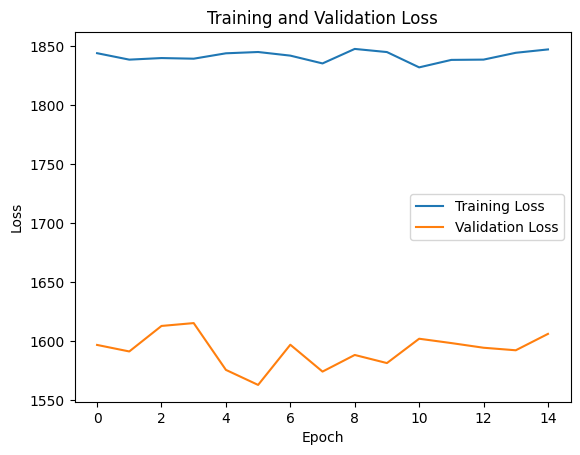

In [17]:
import torch.optim as optim

torch.cuda.empty_cache()

model_name = "amazon/chronos-t5-tiny"
quantization_bits=None
pipeline = load_model(model_name, quantization_bits)

NUM_EPOCHS = 1000
NUM_SAMPLES = 5
EARLY_STOPPING_PATIENCE = 20
INITIAL_LR = 0.001

best_val_loss = np.inf
patience_counter = 0

train_set = train_dataloader
val_set = val_dataloader
train_losses = []
val_losses = []

fig, ax = plt.subplots()

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(pipeline.model.parameters(), lr=INITIAL_LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Example scheduler

for epoch in range(NUM_EPOCHS):

    # Training loop
    pipeline.model.train()
    epoch_train_loss = 0
    for inputs, targets in tqdm(train_set, desc="Training"):
        optimizer.zero_grad()
        outputs = pipeline.predict(inputs,prediction_length=prediction_window,num_samples=NUM_SAMPLES)

        # Calculate the low, median, and high quantiles across the second dimension (dimension with size 3)
        quantiles = torch.quantile(outputs.cpu(), q=torch.tensor([0.1, 0.5, 0.9]), dim=1)
        median = quantiles[1]
        
        loss = criterion(median,targets)
        if not loss.requires_grad:
            loss = loss.clone().requires_grad_(True)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    train_losses.append(epoch_train_loss / len(train_set))

    # Validation loop
    pipeline.model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        
        for inputs, targets in tqdm(val_set, desc="Validating"): # Use your validation dataloader here
            outputs = pipeline.predict(inputs, prediction_length=prediction_window, num_samples=NUM_SAMPLES)
            
            quantiles = torch.quantile(outputs.cpu(), q=torch.tensor([0.1, 0.5, 0.9]), dim=1)
            median = quantiles[1]
            
            loss = criterion(median, targets)
            epoch_val_loss += loss.item()
    
    val_losses.append(epoch_val_loss / len(val_set))

    # Check for early stopping
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break
    
    # Step the scheduler
    scheduler.step()

    # Get the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    
    # Update the plot
    ax.clear()
    ax.plot(train_losses, label='Training Loss')
    ax.plot(val_losses, label='Validation Loss')
    ax.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    
    # Save the plot to a file
    plt.savefig(f'loss_plot.png')
    
    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Learning Rate: {current_lr:.6f}")

# Generate the current timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the final plot to a file after all epochs
ax.clear()
ax.plot(train_losses, label='Training Loss')
ax.plot(val_losses, label='Validation Loss')
ax.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss {model_name}\n Initial lr={INITIAL_LR}, Num_samples={NUM_SAMPLES}, Batch_size={BATCH_SIZE}')
plt.savefig(f'final_loss_{timestamp}.png')

### Push finetuned model to hugging 

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
pipeline.model.model.push_to_hub("moschouChry/chronos-t5-small-fine-tuned_attempt1")